# Hands On 10: Simulators

In this notebook, we will play with other ideal simulators than LinAlg.


## Matrix Product State

**qat.mps**: a simulator where the state vector is stored as a Matrix Product State. This data structure compresses information in slightly entangled cases. In these cases, both memory usage and execution time are greatly reduced. Some references on MPS simulation of quantum computing: [Vidal03](https://arxiv.org/abs/quant-ph/0301063) or [Banuls05](https://arxiv.org/abs/quant-ph/0503174) <br><br>
    *Restrictions:* gates are limited to arity < 4 and need to act on neighboring qubits (*i-e* with consecutive qubit indices).
    <br><br>

As an example we are going to first create a 50-qubit QFT circuit. 

To do so we need to:
- import everything from qat.lang.AQASM
- import the QFT function from qat.lang.AQASM.qftarith

In [2]:
from qat.lang.AQASM import *
from qat.lang.AQASM.qftarith import QFT

Now we can create a 50-qubit circuit with a QFT:
- define the number of qubits
- allocate your qubit
- apply the QFT

In [ ]:
nqbits = 50
prog = Program()
reg = prog.qalloc(nqbits)
prog.apply(QFT(nqbits), reg)
qft_c = prog.to_circ()
%qatdisplay qft_c

We can know create the job from our circut.

In [ ]:
job = qft_c.to_job(nbshots=5) # Note that we are leaving aggregate_data to default True

We need to import MPS.

Once MPS imported we can create our qpu without forgetting to put Innize to True since our circuit is not Innize and MPS needs such circuit.

In [ ]:
from qat.qpus import MPS
qpu = MPS(lnnize=True) # making circuit MPS-compatible. 

We can now submit this job and print the results:

In [ ]:
res = qpu.submit(job)
for sample in res:
    print(sample.state,sample.probability)

Normaly, you have been able to create a circuit with more than 38 qubits using the MPS simulator.

## Stabilizer

**qat.stabs**: a simulator based on the stabilizer formalism ([Gottesman97](https://arxiv.org/abs/quant-ph/9705052), [Aaronson04](https://arxiv.org/abs/quant-ph/0406196)). It is, by construction, restricted to circuits containing Clifford gates (H, CNOT, S and the gates they generate) only. However, on these circuits, it can push the simulation to thousands of qubits.<br><br>
    *Restrictions:* only Clifford gates can be used (CNOT, H, S and everything they generate)<br><br>

If only Clifford gates are used, the stabs simulator, based on the stabilizer formalism, is the most reasonable choice. <br>

Such circuits emerge when working with quantum error correction, for instance.<br>

Then, if noise is modeled as random Pauli gates insertion, you could still use this simulator.<br>

The following piece of code presents the simulation of a noisy encoding of a state into the Steane code.

In this section about the simulator Stabs we will implement the encoder of the famous 7-qubit Steane code.

The logical state to prepare is just $|0_{L}\rangle$, and the starting state is $|0\rangle^{\otimes\cdot n_{\text{physical qubits}}}$. 

$$|0_{L}\rangle = \frac{1}{\sqrt{8}} (|0000000>+|0011110>+|0101101>+|0110011>+\\|1001011>+|1010101>+|1100110>+|1111000>)$$



  We will first implement a QRoutine of our encoder. The circuit you need to implement is the following:
  ![7-qubit steane encoder](./encoder.PNG)
  
  The qubit 6 (starting at 0) is the input. At the end of this circuit we get a logical qubit on 7 qubits. 
  
  Let first create the QRoutine :

In [3]:
from qat.lang.AQASM import *
def my_steane_encoder():
    steane_encoder = QRoutine()
    
    steane_encoder.apply(H,0)
    steane_encoder.apply(H,1)
    steane_encoder.apply(H,2)
    
    steane_encoder.apply(CNOT,6,5)
    steane_encoder.apply(CNOT,6,4)
    steane_encoder.apply(CNOT,1,4)
    steane_encoder.apply(CNOT,0,3)
    steane_encoder.apply(CNOT,2,5)
    steane_encoder.apply(CNOT,1,3)
    steane_encoder.apply(CNOT,0,6)
    steane_encoder.apply(CNOT,2,3)
    steane_encoder.apply(CNOT,1,6)
    steane_encoder.apply(CNOT,0,5)
    steane_encoder.apply(CNOT,2,4)
    return steane_encoder

Once the QRoutine is created we need to create a program to apply it.

Create a program for a single logical qubit with this Steane encoder:

In [4]:
n_logical = 1

prog = Program()

reg = prog.qalloc(7*n_logical)

### Now we can apply our Steane encoder to our register:

In [5]:
for qb in range(n_logical):
    prog.apply(my_steane_encoder(),reg[qb*7:(qb+1)*7])     

Let's display our circuit:

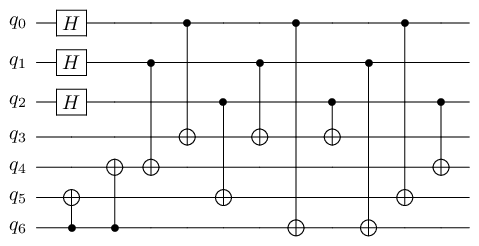

number of qbits:  7
number of gates:  14


In [7]:
qec = prog.to_circ()

%qatdisplay qec
print("number of qbits: ", qec.nbqbits)
print("number of gates: ", len(qec.ops))

We can now import the simulatior Stabs from qat.stabs to execute our job and see if we managed to create the $|0_{L}\rangle$:

In [8]:
from qat.qpus import Stabs

job = qec.to_job(nbshots=0)

qpu = Stabs()

res = qpu.submit(job)

for sample in res:
    print(sample.state,sample.probability)

|0000000> 0.12499999999999997
|0011110> 0.12499999999999997
|0101101> 0.12499999999999997
|0110011> 0.12499999999999997
|1001011> 0.12499999999999997
|1010101> 0.12499999999999997
|1100110> 0.12499999999999997
|1111000> 0.12499999999999997


Modify the input to have $|1\rangle$ as an input state (the 7th physical qubit of each logical qubit is the input) for the logical qubit to create $|1_{L}\rangle$. with $$|1_{L}\rangle = (|1111111>+|1100001>+|1010010>+|1001100>+\\|0110100>+|0101010>+|0011001>+|0000111>)$$


What is the ouput of a logical qubit if the input is $\frac{|0>+|1>}{\sqrt{2}}$ ?


## Feynman

**qat.feynman**: a simulator based on the Feynman path integral formulation of quantum computing (see [Rudiak-Gould06](https://arxiv.org/abs/quant-ph/0607151) for instance). Its execution time is exponential in the number of *dense* gates. A gate is dense if it is neither logical (like CNOT or Toffoli - containing one 1 per line and column) nor diagonal. As qat.linalg, its memory usage is exponential in the number of qubits, as it still computes the entire amplitude vector.<br><br>
    *Restrictions:* gates are limited to arity < 4.
    <br><br>
    
To show an efficient example of Feynman we will use the add function:
- import add from qat.lang.AQASM.classarith
- call the add function

In [ ]:
from qat.lang.AQASM import *
from qat.lang.AQASM.classarith import add

nqbits = 20
prog = Program()
reg = prog.qalloc(nqbits)
for qb in reg[::2]:
    prog.apply(X, qb)     
prog.apply(add(10,10), reg)     
        
adder_c = prog.to_circ()
%qatdisplay adder_c

Let's execute it on MPS first:
- import MPS from qat.qpus
- Create the MPS qpu
- Put Innize to True

In [ ]:
from qat.qpus import MPS 

job = adder_c.to_job(nbshots=100)

qpu = MPS(lnnize=True)

res = qpu.submit(job)

for sample in res:
    print(sample.state,sample.probability)

Let's now compare with Feynman:
- import Feynman from qat.qpus
- Create the Feynman qpu

In [ ]:
from qat.qpus import Feynman 

qpu = Feynman()

res = qpu.submit(job)

for sample in res:
    print(sample.state,sample.probability)

Normaly, qat.feynman is the fastest method for this kind of circuit. This is because there is only "one path in the integral".